In [18]:
import json
from urllib.request import urlopen
import pandas as pd
import numpy as np
import time
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import lxml
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
topic_name = input("기술명을 입력해 주세요. : ")
url = "https://github.com/topics/{}?o=desc&s=stars".format(topic_name)
# 내 컴퓨터의 User_Agent
res= requests.get(url)
res.raise_for_status()
soup=BeautifulSoup(res.text,"lxml")
soup
options = webdriver.ChromeOptions()
# headless option임

# options.add_argument("headless")
# browser = webdriver.Chrome("./chromedriver",options=options)
browser = webdriver.Chrome("./chromedriver")
browser.get(url)
soup = BeautifulSoup(browser.page_source,'lxml')
# Load more 을 몇번 누를것인지??
# 임의로 100번을 했지만 star수가 예를들어 x개 이상일때까지 Load_more버튼을 누르는 식으로도 가능
Load_more_times = 100
for _ in range(Load_more_times):
    prev = len(soup.find_all("article",attrs={"class":"border rounded color-shadow-small color-bg-subtle my-4"}))
    try:
        browser.find_element_by_xpath("/html/body/div[4]/main/div[2]/div[2]/div/div[1]/form/button").click()
    except:
        print("End")
        break
    while 1:
        soup = BeautifulSoup(browser.page_source,'lxml')
        if prev < len(soup.find_all("article",attrs={"class":"border rounded color-shadow-small color-bg-subtle my-4"})):
            prev = len(soup.find_all("article",attrs={"class":"border rounded color-shadow-small color-bg-subtle my-4"}))
            break
    print(prev,"개 load 완료.")
    
# Topic들을 Crawling후 나열 
soup = BeautifulSoup(browser.page_source,'lxml')
topics = soup.find_all("h3",attrs={"class":"f3 color-fg-muted text-normal lh-condensed"})
topic_ads = []
for i in topics:
    topic_ad = "".join(i.get_text().strip().replace("\n","").split()) 
    topic_ads.append(topic_ad)

    


기술명을 입력해 주세요. : azure


/var/folders/77/bz3g3h4j4hbbknntq2tmr9h80000gn/T/ipykernel_82900/3713712168.py:13: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  browser = webdriver.Chrome("./chromedriver")
/var/folders/77/bz3g3h4j4hbbknntq2tmr9h80000gn/T/ipykernel_82900/3713712168.py:22: DeprecationWarning: find_element_by_xpath is deprecated. Please use find_element(by=By.XPATH, value=xpath) instead
  browser.find_element_by_xpath("/html/body/div[4]/main/div[2]/div[2]/div/div[1]/form/button").click()


NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=107.0.5304.87)
Stacktrace:
0   chromedriver                        0x00000001008caf44 chromedriver + 3813188
1   chromedriver                        0x000000010085cae0 chromedriver + 3361504
2   chromedriver                        0x0000000100560c5c chromedriver + 232540
3   chromedriver                        0x000000010054371c chromedriver + 112412
4   chromedriver                        0x00000001005aeebc chromedriver + 552636
5   chromedriver                        0x00000001005bf638 chromedriver + 620088
6   chromedriver                        0x0000000100587358 chromedriver + 389976
7   chromedriver                        0x0000000100588284 chromedriver + 393860
8   chromedriver                        0x000000010089ee18 chromedriver + 3632664
9   chromedriver                        0x00000001008a297c chromedriver + 3647868
10  chromedriver                        0x00000001008a8b58 chromedriver + 3672920
11  chromedriver                        0x00000001008a3350 chromedriver + 3650384
12  chromedriver                        0x00000001008808dc chromedriver + 3508444
13  chromedriver                        0x00000001008bd914 chromedriver + 3758356
14  chromedriver                        0x00000001008bda78 chromedriver + 3758712
15  chromedriver                        0x00000001008d16cc chromedriver + 3839692
16  libsystem_pthread.dylib             0x000000019386226c _pthread_start + 148
17  libsystem_pthread.dylib             0x000000019385d08c thread_start + 8


In [20]:
# Topic들을 Crawling후 나열 
soup = BeautifulSoup(browser.page_source,'lxml')
topics = soup.find_all("h3",attrs={"class":"f3 color-fg-muted text-normal lh-condensed"})
topic_ads = []
for i in topics:
    topic_ad = "".join(i.get_text().strip().replace("\n","").split()) 
    topic_ads.append(topic_ad)
topic_ads

['tensorflow/tensorflow',
 'huggingface/transformers',
 'keras-team/keras',
 'aymericdamien/TensorFlow-Examples',
 'CorentinJ/Real-Time-Voice-Cloning',
 'google-research/bert',
 'xitu/gold-miner',
 'ageron/handson-ml',
 'donnemartin/data-science-ipython-notebooks',
 'photoprism/photoprism',
 'ray-project/ray',
 'matterport/Mask_RCNN',
 'deezer/spleeter',
 'mozilla/DeepSpeech',
 'lutzroeder/netron',
 'MLEveryday/100-Days-Of-ML-Code',
 'instillai/TensorFlow-Course',
 'Tencent/ncnn',
 'd2l-ai/d2l-en',
 'huggingface/datasets']

In [11]:
# topics 이 들어갈 dic
topics_dic = {}
topics_list= []

def Crawling(ad):
    global topics_dic
    global topics_list  
    url_topic = "https://github.com/" + ad
    res_topic = requests.get(url_topic)

    soup_topic = BeautifulSoup(res_topic.text,"lxml")
    try:
        topic = soup_topic.find("div",attrs={"class":"BorderGrid-cell"}).find_all("a",attrs={"class":"topic-tag topic-tag-link"})
    except:
        time.sleep(1)
        Crawling(ad)
        return
    project_topics=[i.get_text().replace("\n","").replace("\t","").strip() for i in topic]
    topics_list.append([topic_ads[idx],project_topics])
    for t in project_topics:
        if t in topics_dic:
            topics_dic[t] += 1
        else:
            topics_dic[t] = 1

# 한번의 loop마다 주소생성,soup생성,Crawling을 하기때문에 코드 실행시간이 매우 오래걸림
for idx,ad in enumerate(topic_ads):
    print("{}% 완료".format(round(((idx+1)*100/len(topic_ads)),2)))
    Crawling(ad)


topics_dic= sorted(topics_dic.items(), key=lambda x: x[1], reverse=True)

df_keyword = pd.DataFrame(topics_list,columns=['project_name','topic_keyword'])
df_keyword.to_excel("keyword({}).xlsx".format(topic_name))
print("keyword({}).xlsx".format(topic_name),"저장완료.")

5.0% 완료
10.0% 완료
15.0% 완료
20.0% 완료
25.0% 완료
30.0% 완료
35.0% 완료
40.0% 완료
45.0% 완료
50.0% 완료
55.0% 완료
60.0% 완료
65.0% 완료
70.0% 완료
75.0% 완료
80.0% 완료
85.0% 완료
90.0% 완료
95.0% 완료
100.0% 완료
keyword(tensorflow).xlsx 저장완료.


In [20]:
df_keyword.head(20)

project_name  \
0                             tensorflow/tensorflow   
1                                     opencv/opencv   
2                                  keras-team/keras   
3                                   pytorch/pytorch   
4                 aymericdamien/TensorFlow-Examples   
5                                deepfakes/faceswap   
6                     Avik-Jain/100-Days-Of-ML-Code   
7                                        BVLC/caffe   
8                 CorentinJ/Real-Time-Voice-Cloning   
9    floodsung/Deep-Learning-Papers-Reading-Roadmap   
10                               iperov/DeepFaceLab   
11                          GokuMohandas/MadeWithML   
12                                    d2l-ai/d2l-zh   
13  ZuzooVn/machine-learning-for-software-engineers   
14                              naptha/tesseract.js   
15                                ageron/handson-ml   
16             terryum/awesome-deep-learning-papers   
17            CMU-Perceptual-Computing-Lab/openpose   
18                          yunjey/pytorch-tutorial   
19       donnemartin/data-science-ipython-notebooks   

                                        topic_keyword  
0   [python, machine-learning, deep-neural-network...  
1   [opencv, c-plus-plus, computer-vision, deep-le...  
2   [python, data-science, machine-learning, deep-...  
3   [python, machine-learning, deep-learning, neur...  
4   [python, machine-learning, tutorial, deep-lear...  
5   [machine-learning, deep-neural-networks, deep-...  
6   [python, machine-learning, tutorial, deep-lear...  
7           [machine-learning, deep-learning, vision]  
8   [python, deep-learning, tensorflow, pytorch, t...  
9                                     [deep-learning]  
10  [deep-neural-networks, deep-learning, faceswap...  
11  [python, data-science, machine-learning, natur...  
12  [python, machine-learning, natural-language-pr...  
13  [machine-learning, deep-learning, machine-lear...  
14  [javascript, ocr, deep-learning, webassembly, ...  
15  [python, machine-learning, deep-learning, neur...  
16  [machine-learning, deep-neural-networks, deep-...  
17  [opencv, machine-learning, real-time, caffe, c...  
18  [deep-learning, pytorch, neural-networks, pyto...  
19  [python, aws, data-science, machine-learning, ...

### 해당 ipynb 경로에 (토픽 이름).xlsx 파일 형태로 저장

In [22]:
# 비슷한 토픽끼리는 하나의 칼럼이 될 수 있도록 일일히 비슷한 토픽끼리 묶는 작업을 하였음
target = ['machinelearning','package','zsh','zerossl','youtube','xcode','x64','wysiwyg','workflow','windows','weixin','wechat','web','vue',
         'vpn','vision','vim','vedio','version','util','ui','typescript','twitter','touch','test','terminal','tensorflow',
         'telegram','task','system','swift','swagger','svg','style','static','state','ssh','sql','spring','sort','software',
         'snippets','server','security','search','scikit-learn','rfc','rest','redis','react','queue','pytorch','python','protoc','progress',
         'programming','posix','php','performance','openwrt','note','nodejs','neural','nlp','monitoring','microservice','material','macos','linux',
          'leetcode','language','kotlin','json','javascript','ios','interview','http','html','headless','graphql','git','frontend','font','flutter',
          'firefox','file','face-swap','docker','distributed','design','deep-learning','data','css','cloud','chrome','automation','api','angular',
          'android','algorithm','pull-request', 'public','pixi','open-source','object-detection','multi-platform','mini','low-code','localstorage','loading',
          'kubernetes','koa','image','humans','game','free','detection','drag','document','devops','dashboard','crypto','cpp','continuous-delivery','command','cheatsheet',
          'certificate','business','build','bootstrap','awesome','audio','apple','apache','ansi','animation','alibaba','admin','activejob'
         ]



string_list = [['machinelearning-python','ml','machine-translation','machine-learning-from-scratch','machine-learning-algorithms','machine-learning'],['packages','package-manager','packaging'],['zsh-theme','zsh-prompt','zsh-configuration','zsh-autosuggestions'],['zero-copy','zero-configuration'],['youtube-live'],['xcode10'],['x86-64','x86'],['wysiwyg-editor'],
               ['workflow-automation','works-with-clojurescript','works-with-codespaces','works-with-construct','works-with-elm','works-with-flutter','works-with-gatsby','works-with-mint','works-with-phaser','works-with-react','works-with-reason','works-with-svelte','works-with-vue','works-with-yew'],
               ['windowing','windows-10','windows-console','windows-terminal','windowscontainers'],['weixin-plugin'],['wechat-macos','wechat-mini-program','wechat-plugin','wechat-weapp'],
               ['webxr','webworkers','webview','webtorrent','webstorm','websql','websockets','websocket-server','websocket-compression','websocket-client','websocket','website','webservices','webscraping','webrtc','webpack5','webpack4','webpack2','webpack','webp','webm','webgpu','webgl2','webgl','webframework','webfont','webfinger','webdriver','webdevelopment','webdav','webcomponents','webbrowser','webaudio','webassembly','webapp','webapi','web-terminal','web-server','web-performance','web-framework','web-development','web-components','web-clipper','web-audio','web-application-framework','web-application','web-app','web','sdwebimage','react-native-web','node-webkit','mobile-web','ipfs-web'],
               ['vuex','vuetifyjs','vuetify','vuepress','vuejs3','vuejs2','vuejs','vue3','vue2','vue-router','vue-material','vue-components','vue-component','vue-cli','vue-admin','ant-design-vue'],
               ['vpn-server','vpn-client'],['visual-studio','visualizer','visualizations','visualization','visual-studio-code-theme','visual-studio-code-extension','visual-studio-code','visual-studio','data-visualization'],
               ['vimrc','vimeo','vim-plugins','vim-plugin','vim-distribution','vim-configuration','vim'],['videojs','videocache','video-recording','video-player','video-conferencing','video-communication','video','scalable-video-conferences','html5-video','explanatory-math-videos','deep-video','3b1b-videos'],
               ['versioning','version-manager'],['utils','utility-classes','utilities'],['ui-library','ui-kit','ui-design','ui-components','redis-gui-client','gui-framework','gui-app'],
               ['typescript-playground','typescript-framework','typescript-definitions','typescript'],['twitter-streaming','twitter-cards','twitter','tweet'],
               ['touchscreen','touch-events','touch'],['unit-testing','tests','testing-tools','testing','test-suite','test-runners','test-runner','test-framework','test-automation','performance-testing','pentesting-windows','pentesting','pentesters','pentest','penetration-testing','painless-javascript-testing','load-testing','javascript-tests','interview-test','end-to-end-testing','e2e-tests','e2e-testing','api-testing','api-test'],
               ['windows-terminal','web-terminal','terminals','terminal-themes','terminal-schemes','terminal-emulators','terminal-color','terminal','osx-terminal-themes','lxterminal'],
               ['tensorflow-lite','tensorflow','tensor'],['telegram-solution','telegram-desktop'],['task-scheduler','task-runner','task-manager'],
               ['systems-science','systems','system-design','system','recommendedsystem','operating-system','management-system','fuse-filesystem','filesystem','embedded-systems','distributed-systems','design-systems','design-system','database-systems','content-management-system','build-system'],
               ['swiftyjson','swiftui','swiftpm','swift4-2','swift-programming','swift-package-manager','swift-library','swift-language','swift-framework','swift-extensions','swift','server-side-swift','rxswift','reactiveswift','openstack-swift','json-parsing-swift','ios-swift','awesome-swift','apple-swift'],
               ['swagger2','swagger-ui','swagger-js','swagger-api'],['svgo','svg-sprites','svg-path','svg-icons'],['stylesheets','stylesheet-language','styleguide','styled-components','style-linter','style-guide'],
               ['static-site-generator','static-code-analysis','static-analysis'],['statechart','state-tree','state-management','state-machine'],
               ['ssh-tunnel','ssh-server','ssh-agent'],['websql','sqlserver','sqlmap','sqlite','sql-server','sql-injection','sql-editor','sql','spark-sql','postgresql','nosql','mysql-compatibility','mysql','mssql','microsoft-sql-server'],
               ['springs','springmvc','springcloud-config','springcloud','springbootadmin','springboot-shiro','springboot','spring-session','spring-security','spring-physics','spring-framework','spring-data-jpa','spring-cloud-core','spring-cloud-alibaba','spring-cloud','spring-cache','spring-boot-upload-file','spring-boot-mongodb','spring-boot-mail','spring-boot-learning','spring-boot-examples','spring-boot-demo','spring-boot-2','spring-boot','spring','react-spring'],
               ['sorts','sorting-algorithms','sortable'],['software-engineering','software-engineer','software-development','software-analysis'],
               ['snippets-library','snippets-collection','snippets'],['websocket-server','web-server','vpn-server','ssh-server','sqlserver','sql-server','serverless-functions','serverless-framework','serverless-architectures','serverless','server-side-swift','server-side-rendering','server-rendering','server','parse-server','observer','microsoft-sql-server','jumpserver','http-server','graphql-server','dns-server','dhcp-server','dev-server','api-server'],
               ['spring-security','security-researchers','security-checklist','security-book','security','macos-security','macbook-security','docker-security','application-security'],
               ['site-search','silver-searcher','security-researchers','searches','search-in-text','search-engines','search-engine','search','research','jobsearch','jobs-search','hyperparameter-search','entreprise-search','elasticsearch','distributed-search-engine'],
               ['scikit-learn-python','scikit-learn'],['rfc-8259','rfc-7159','rfc-7049','rfc-6902','rfc-6901','rfc-6455'],['restful-api','restful','rest-api','rest','postgrest','api-rest','admin-on-rest'],
               ['redis-gui-client','redis-gui','redis-cluster','redis-client'],['works-with-react','reactjs','reactivex','reactiveui','reactiveswift','reactivecocoa','reactive-streams','reactive-programming','reactive','react16','react-tutorial','react-spring','react-router','react-navigation','react-native-web','react-native','react-interview-questions','react-hooks','react-components','react-component','react-boilerplate','react-apps','react-admin'],
               ['sqs-queue','queued-jobs','queue-workers','queue-tasks','queue','message-queue'],['pytorch-tutorial','pytorch-transformers'],['scikit-learn-python','python3','python-types','python-resources','python-requests','python-library','python-interview-questions','python-framework','python-cheatsheet','python-3','python','progress-bar-python'],
               ['protocol-compiler','protocol-buffers','protocol','protoc','ipfs-protocol','homekit-accessory-protocol','acme-protocol'],['progressmeter','progressbar','progress-bar-python','progress-bar'],['swift-programming','reactive-programming','programming-tutorial','programming-ligatures','programming-language','programming-interviews','programming-blogs','programming','programmer','javascript-programming','functional-programming','dynamic-programming-algorithm','dynamic-programming','concurrent-programming','competitive-programming'],
               ['posix-sh','posix-compliant-flags','posix-compliant'],['phpunit','phpstorm','phpmailer','php8','php7','php-library','php-installation','php-framework','php-applications','php','modern-php','designpatternsphp'],
               ['web-performance','performance-testing','performance-metrics','performance-analysis','performance','high-performance','best-performance'],
               ['openwrt-zh-cn','openwrt-shadowsocksr-libev-full','openwrt-package','openwrt-feed'],['notes','notebooks','notebook','note','jupyter-notebook','evernote'],['nodemon','nodejs-framework','nodejs-development','nodejs','node-webkit','node-module','node-js','node-framework','node'],
               ['neural-networks','neural-network','neural-nets','deep-neural-networks'],['natural-language-understanding','natural-language-processing','natural-language-generation','nlp-tasks','nlp-library'],['monitoring','monitor','error-monitoring','docker-monitoring'],
               ['polyglot-microservices','microservices-architecture','microservices'],['vue-material','training-materials','material-ui','material-theme','material-design-lite','material-design-for-bootstrap','material-design','material-components','material','bootstrap-material','angularjs-material'],
               ['wechat-macos','macosx','macos-setup','macos-security','macos-application'],['ubuntu-linux','linux-resource','linux-kernel','linux-insides','linux-desktop','linux-command','linux-app'],
               ['leetcode-solutions','leetcode-questions','leetcode-java','leetcode-golang','leetcode-go','leetcode-c'],['swift-language','stylesheet-language','ruby-language','programming-language','natural-language-understanding','natural-language-processing','natural-language-generation','multi-language','language-models','language-model','language-grammars','language-client','language','julia-language','esoteric-language'],
               ['kotlin-library','kotlin-android'],['ubjson','swiftyjson','json-serializer','json-serialization','json-schema','json-pointer','json-patch','json-parsing-swift','json-parsing-library','json-parser','json-merge-patch','json-diff','json','fastjson'],['painless-javascript-testing','javascript-tests','javascript-programming','javascript-motion-engine','javascript-modules','javascript-library','javascript-interview-questions','javascript-framework','javascript-engines','javascript-engine','javascript-compiler','javascript-closures','javascript-best-practices','javascript-applications','javascript-algorithms','javascript','es6-javascript','js-questions','js-ipfs','js'],
               ['ios-transition','ios-swift','ios-libraries','ios-lib','ios-framework','ios-animation'],['technical-coding-interview','react-interview-questions','rails-interview','python-interview-questions','programming-interviews','javascript-interview-questions','interviews','interviewing','interview-test','interview-questions','interview-preparation','interview-prep','interview-practice','interview','frontend-interview','front-end-interview','fe-interview','coding-interviews','coding-interview','angularjs-interview-questions','android-interview-questions'],
               ['httpurlresponse','https','httpie','httpclient','http2','http-server','http-proxy','http-client','http','automatic-https'],['htmlparser2','htmlparser','html5-video','html5-games','html5-game-development','html5-charts','html5-canvas','html5-boilerplate','html5-audio','html5','html-template','html-questions'],['headless-cms','headless-chrome','headless-browser'],
               ['graphql-server','graphql-relay','graphql-js','graphql-client','graphql-api','graphql','apollographql'],['hellogithub','gitops','gitlab','gitignore','github-pages','github-gist','github-api-v4','github-api','github-actions','github','gitea','gitbook','git'],['frontend-roadmap','frontend-interview','frontend-framework','frontend-development','frontend','front-end-interview','front-end-development','front-end-developer-tool','front-end'],
               ['webfont','variable-fonts','ttf-fonts','patched-fonts','opentype-fonts','iconic-fonts','icon-font','fonts','fontawesome','font-awesome'],['works-with-flutter','flutter-plugins','flutter-plugin','flutter-examples','flutter-doc','flutter-demo','flutter-apps'],['firefox-extension','firefox-addon'],['filesystem','files','file-uploads','file-uploader','file-upload','file-storage','file-sharing','file-manager','file-management'],
               ['openfaceswap','faceswap','face-swap','face-recognition','face-images','face-detection','deepfacelab','deepface','deep-face-swap'],['dockerfile','docker-ui','docker-swarm','docker-security','docker-registry','docker-monitoring','docker-machine','docker-image','docker-environment','docker-deployment','docker-container','docker-composer','docker-compose','docker-api'],['distributed-transactions','distributed-transaction','distributed-training','distributed-tracing','distributed-systems','distributed-search-engine','distributed-messaging','distributed-locks','distributed-database','distributed-configuration','distributed'],
               ['ui-design','system-design','material-design-lite','material-design-for-bootstrap','material-design','designpatternsphp','design-tools','design-systems','design-system','design-patterns-for-humans','design-patterns','design-pattern','design','api-design','ant-design-vue','ant-design'],['deepspeech','deeplearning','deepfakes','deepfacelab','deepface','deep-video','deep-reinforcement-learning','deep-neural-networks','deep-networks','deep-learning-tutorial','deep-learning','deep-io','deep-face-swap','creating-deepfakes'],['datasets','datamatrix','datamapper','datagrip','databricks','databases','database-systems','database-gui','database','data-viz','data-visualization','data-structures','data-structure','data-scientists','data-science','data-mining','data-mapper','data-flow','data-fetching','data-engineering','data-consistency','data-analytics','data-analysis'],
               ['functional-css','csse','css3-features','css3','css-tricks','css-reset','css-questions','css-in-js','css-framework','css-effects','css-animations'],['springcloud-config','springcloud','spring-cloud-core','spring-cloud-alibaba','spring-cloud','private-cloud','nextcloud','neteasecloud','google-cloud-storage','google-cloud-functions','cloudstorage','cloudnative','cloudmusic','cloudflare','cloud-storage','cloud-native','cloud-management','cloud-computing'],['headless-chrome','chrome-extensions','chrome-extension','chrome-devtools'],['zsh-autosuggestions','workflow-automation','test-automation','home-automation','build-automation','autosuggest','autopep8','autonomy','autonomous-vehicles','autonomous-driving','automl','automation','automatic-https','automatic-api','automated','autolayout','autograd','autocompletion','autocomplete','auto'],
               ['webscraping','webapi','swagger-api','strapi','scraping','restful-api','rest-api','public-apis','openapi3','openapi-specification','openapi','homekit-api','hapi','graphql-api','github-api-v4','github-api','fastapi','dom-apis','docker-api','automatic-api','apis','api-testing','api-test','api-server','api-rest','api-manager','api-management','api-gateway','api-documentation','api-design','api-client'],['angularjs-material','angularjs-interview-questions','angularjs','angular9','angular2','angular10','angular-dashboard-template','angular-components','angular-cli'],['mpandroidchart','kotlin-android','androidx','android-ui','android-studio','android-library','android-interview-questions','android-development','android-architecture'],
               ['sorting-algorithms','machine-learning-algorithms','javascript-algorithms','genetic-algorithm','dynamic-programming-algorithm','algorithms-implemented','algorithms-datastructures','algorithms-and-data-structures','algorithms','algorithm-competitions','algorithm-challenges'],
               ['pulltorefresh','pull-to-refresh','pull-request-review'],['public-trackers','public-tracker','public-key-pinning'],['pixiv','pixijs'],['openwrt','openvpn','openssl','opensource','openpose','opengl','opendata','opencv','openconnect','open-telemetry','open-source-project'],['objectstorage','objective-c-library','objective-c','object-storage','object-oriented'],['multithreading','multimedia','multiformats','multiboot','multi-platform','multi-person'],['miniprogram','minimalist','minikube','minify','minifier','minification','miniapp'],['low-code-plattform','low-code-development-platform','low-code'],
               ['localstack','localhost','localforage','local-development'],['loading','loaders','load-generator','load-balancer'],['kubernetes-ingress-controller','kubernetes-ingress'],['koa2','koa-middleware'],['imageloader','image-processor','image-processing','image-annotation'],['human-pose-estimation','human-pose','human-behavior-understanding','forhumans'],['puzzle-game','platform-game','not-the-game','games','gamedev','game-frameworks','game-engine','game-development','game-capture','game','facebook-instant-games'],['freeware-icon','freegate','freecodecamp','freebsd-vt','free-ssr','free-ss','free-software','free-fanqiang'],['object-detection','keypoint-detection','intrusion-detection','feature-detection'],['dragging','draggable','drag-drop','drag-and-drop'],['documentation-tool','documentation'],['devops-roadmap'],
                ['hystrix-dashboard','dashboards','dashboard-templates','dashboard','admin-dashboard'],['cryptography','cryptocurrency'],['cpplint','cppcon','cpp11','cpp-library'],['continuous-integration','continuous-deployment'],['subcommands','commandline','command-line-tool','command-line','command-cobra'],['cheatsheets'],
               ['certification','certificates','certificate-pinning'],['businessintelligence','business-intelligence','business-analytics'],['form-builder','buildpack','build-tools','build-tool','build-pipelines'],['secure-boot','multiboot','jeecgboot','jeecg-boot','bootstrap5','bootstrap4-theme','bootstrap4','bootstrap','bootable-usb'],['awesomeness','awesome-public-datasets','awesome-lists','awesome-list'],['audio-processing','audio-library'],['apple-watch','apple-tv','apple'],['apache-superset','apache-airflow'],['strip-ansi','ansible','ansi-escape-codes','ansi-colors','ansi'],['transition-animation','recyclerview-item-animation','animations','animation-library'],['alibaba-oss','alibaba-middleware'],['ngx-admin','ng2-admin','eladmin','adminpanel','admin-ui','admin-template','admin-panel','admin-dashboard'],
               ['activerecord','activemq','activejob','active-record']
                
              ]
def same_things(string):
    for idx,i in enumerate(string_list):
        if string in i:
            string = target[idx]    
    return string

In [24]:
topic_dic = {}
for idx,j in enumerate(df_keyword['topic_keyword']):
    for i in j:
        i = i.strip()
        i = same_things(i) # 위에서 만든 여러 토픽을 하나의 토픽으로 묶는 함수
        if len(i)==0:
            continue
        if i not in topic_dic:
            topic_dic[i] = 1
        else:
            topic_dic[i] +=1
result = []
topic_dic = sorted(topic_dic.items(), key=lambda x: x[1], reverse=True)

topic_list = [i[0] for i in topic_dic]
# 위 과정들을 통해 얻은 토픽들을 통해 칼럼을 만듬
df_vector = pd.DataFrame(topic_list).transpose()

topic_dic_df = {}
for i in topic_list:
    topic_dic_df[i]=0
# 토픽들을 칼럼으로 가지는 각각의 패키지 별로 벡터를 만들고 모든 성분을 0으로 채움
df_vector = pd.DataFrame(result,index=df_keyword['project_name'],columns=topic_list).fillna(0)

# 각 패키지 별로 가지고있는 토픽을 +1 씩 하여 각 패키지의 벡터를 생성함
for idx,topics in enumerate(df_keyword['topic_keyword']):
    for topic_ in topics:
        if topic_ in topic_list:
            topic_ = same_things(topic_)
            df_vector.loc[df_keyword['project_name'].iloc[idx],topic_] += 1
df_vector.to_excel("keyword({})_vectors.xlsx".format(topic_name),index=False)
print("keyword({})_vectors.xlsx".format(topic_name),"저장완료.\n")


keyword(deep_learning)_vectors.xlsx 저장완료.



## K-Means 클러스터링

K-means의 Cluster 수 : 10
********** deep_learning K-Means 클러스터링 시작 **********


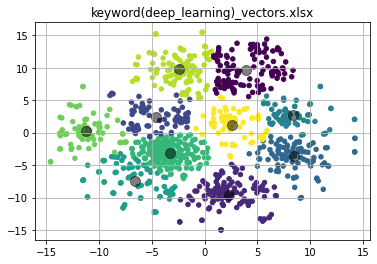

   num                                           clusters  cluster_num  \
0    0  [tensorflow/tensorflow, keras-team/keras, ayme...          124   
1    1  [opencv/opencv, d2l-ai/d2l-zh, CMU-Perceptual-...          122   
2    2  [BVLC/caffe, explosion/spaCy, oxford-cs-deepnl...           79   
3    3  [yunjey/pytorch-tutorial, ultralytics/yolov5, ...          104   
4    4  [GokuMohandas/MadeWithML, fastai/fastai, PyTor...           67   
5    5  [deepfakes/faceswap, iperov/DeepFaceLab, Chris...           82   
6    6  [floodsung/Deep-Learning-Papers-Reading-Roadma...          176   
7    7  [ZuzooVn/machine-learning-for-software-enginee...           80   
8    8  [mozilla/DeepSpeech, photoprism/photoprism, da...          116   
9    9  [pytorch/pytorch, Avik-Jain/100-Days-Of-ML-Cod...           70   

                                       top_15_topics  
0  [(deep-learning, 134), (tensorflow, 124), (mac...  
1  [(deep-learning, 131), (computer-vision, 122),...  
2  [(deep-learning, 

In [27]:
n_clusters = int(input("K-means의 Cluster 수 : "))
print("{} {} K-Means 클러스터링 시작 {}".format("*"*10,topic_name,"*"*10))
excel_name = "keyword({})_vectors.xlsx".format(topic_name)
df_topic = df_keyword
df_vector = pd.read_excel(excel_name)
m = TSNE(learning_rate = 50)
tsne_features = m.fit_transform(pd.DataFrame(df_vector))
df = pd.DataFrame()
df['x'] = tsne_features[:,0]
df['y'] = tsne_features[:,1]
    
if len(df) <= n_clusters:
    print("Repository 가 {}개 미만입니다.".format(n_clusters))
    n_clusters = len(df)//3
    print("{}개의 Cluster로 군집화 시작합니다.".format(n_clusters))
else:
    # 10개의 Cluster 지정
    n_clusters = n_clusters
kmeans = KMeans(n_clusters=n_clusters)
# kmeans = KMeans(n_clusters=4,verbose = 1)

# 모델에 fitting 하기
kmeans.fit(tsne_features)

y_kmeans = kmeans.predict(tsne_features)
y_kmeans[0:10] # 군집화 된 결과
    
plt.scatter(np.array(tsne_features)[:,0], np.array(tsne_features)[:,1], c=y_kmeans, s=20, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:,0], centers[:,1], c='black', s=100, alpha=0.5)
plt.grid()
plt.title(excel_name)
plt.show()
    
    
clustered_dic = {}
clustered_list = []
cluster_num = len(set(y_kmeans))
for idx,i in enumerate(y_kmeans):
    if i not in clustered_dic:
        clustered_dic[i] = [df_topic['project_name'][idx]]
    else:
        clustered_dic[i].append(df_topic['project_name'][idx])
clustered_dic = sorted(clustered_dic.items(), key=lambda x: x[0])
df_cluster = pd.DataFrame(clustered_dic,columns=['num','clusters'])
cluster_num = [len(i) for i in df_cluster['clusters']]
df_cluster['cluster_num'] = cluster_num
    
# 군집화된 패키지들은 어떤 토픽들을 가지고 있을까?
topic_clustered_list = []
for i in df_cluster['clusters']:
    temp_dic = {}
    for j in i:
        topics = list(df_topic[df_topic['project_name']==j]['topic_keyword'].values[0])
        for i in topics:
            if len(i)==0:
                continue
            i = same_things(i.strip())
            if i not in temp_dic:
                temp_dic[i] = 1
            else:
                temp_dic[i] += 1
    temp_dic = sorted(temp_dic.items(), key=lambda x: x[1], reverse=True)
    topic_clustered_list.append(temp_dic[:15])
df_cluster['top_15_topics'] = topic_clustered_list
df_cluster.to_excel("{}_kmeans_10clusters.xlsx".format(topic_name),index=False)
print(df_cluster)
print("{}_kmeans_10clusters.xlsx".format(topic_name),"저장완료")
print("*"*50)
    


## DBSCAN 클러스터링

In [29]:
print("{} {} DBSCAN 클러스터링 시작 {}".format("*"*10,topic_name,"*"*10))
excel_name = "keyword({})_vectors.xlsx".format(topic_name)
df_vector = pd.read_excel(excel_name)
# eps 값을 조정해나가면서 클러스터링을 해야 더 정확한 결과가 나온다
dbscan = DBSCAN(eps = 0.3)
dbscan_cluster = dbscan.fit_predict(df_vector)
dbscan_cluster
dbscan_clustered_dic = {}
dbscan_clustered_list = []
dbscan_cluster_num = len(set(dbscan_cluster))


for idx,i in enumerate(dbscan_cluster):
    if i not in dbscan_clustered_dic:
        dbscan_clustered_dic[i] = [df_topic['project_name'][idx]]
    else:
        dbscan_clustered_dic[i].append(df_topic['project_name'][idx])

# 클러스터링이 된 패키지들
# 20개의 군집으로 생성

dbscan_clustered_dic = sorted(dbscan_clustered_dic.items(), key=lambda x: x[0])

df_dbscan_cluster = pd.DataFrame(dbscan_clustered_dic,columns=['num','clusters'])
dbscan_cluster_num = [len(i) for i in df_dbscan_cluster['clusters']]
df_dbscan_cluster['cluster_num'] = dbscan_cluster_num
topic_dbscan_clustered_list = []
for i in df_dbscan_cluster['clusters']:
    temp_dic = {}
    for j in i:
        topics = df_topic[df_topic['project_name']==j]['topic_keyword'].values[0]
        for i in topics:
            if len(i)==0:
                continue
            i = same_things(i)
            if i not in temp_dic:
                temp_dic[i] = 1
            else:
                temp_dic[i] += 1
    temp_dic = sorted(temp_dic.items(), key=lambda x: x[1], reverse=True)
#     print(temp_dic[:15]) # 상위 15개만 보여줌
#     print()
    topic_dbscan_clustered_list.append(temp_dic[:15])
df_dbscan_cluster['top_15_topics'] = topic_dbscan_clustered_list
df_dbscan_cluster.to_excel("{}_DBSCAN_clusters.xlsx".format(topic_name),index=False)
print(df_dbscan_cluster)
print("{}_DBSCAN_clusters.xlsx".format(topic_name),"저장완료")
print("*"*50)


********** deep_learning DBSCAN 클러스터링 시작 **********
   num                                           clusters  cluster_num  \
0   -1  [tensorflow/tensorflow, opencv/opencv, keras-t...          998   
1    0  [floodsung/Deep-Learning-Papers-Reading-Roadma...           17   
2    1  [philipperemy/tensorflow-1.4-billion-password-...            5   

                                       top_15_topics  
0  [(deep-learning, 1085), (machinelearning, 558)...  
1  [(deep-learning, 20), (machinelearning, 9), (d...  
2  [(deep-learning, 5), (tensorflow, 5), (machine...  
deep_learning_DBSCAN_clusters.xlsx 저장완료
**************************************************
